
# 🫀 Heart Health Prediction Project 


### Workflow:
1. **Imports**
2. **Load Dataset (`df_raw`)** – used for EDA (with categorical columns intact)
3. **Exploratory Data Analysis (EDA)** – pandas + seaborn plots
4. **Preprocessing (`df`)** – one-hot encoding of categorical columns
5. **Train/Test Split**
6. **Model Training & Cross-Validation**
7. **Evaluation on Test Set**
8. **Results Summary**

👉 Important:
- Use `df_raw` for EDA (contains original categorical columns).
- Use `df` for modeling (numeric only, safe for ML).


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set(context="notebook", style="whitegrid")
pd.set_option("display.max_columns", None)


In [2]:

# Load dataset (update path if needed)
csv_path = "heart.csv"
df_raw = pd.read_csv(csv_path)

print("Nulls per column:\n", df_raw.isna().sum())

# Drop missing values in Thal (only 2 rows)
if "Thal" in df_raw.columns:
    df_raw = df_raw.dropna(subset=["Thal"]).reset_index(drop=True)

print("\nShape after cleaning:", df_raw.shape)
df_raw.head()


Nulls per column:
 Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         2
Target       0
dtype: int64

Shape after cleaning: (301, 14)


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,Target
0,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,1
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,0


In [3]:

print("Dataset Info:")
print(df_raw.info())
print("\nSummary Statistics:")
print(df_raw.describe())

print("\nTarget Distribution:")
print(df_raw['Target'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        301 non-null    int64  
 1   Sex        301 non-null    int64  
 2   ChestPain  301 non-null    object 
 3   RestBP     301 non-null    int64  
 4   Chol       301 non-null    int64  
 5   Fbs        301 non-null    int64  
 6   RestECG    301 non-null    int64  
 7   MaxHR      301 non-null    int64  
 8   ExAng      301 non-null    int64  
 9   Oldpeak    301 non-null    float64
 10  Slope      301 non-null    int64  
 11  Ca         301 non-null    int64  
 12  Thal       301 non-null    object 
 13  Target     301 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.1+ KB
None

Summary Statistics:
              Age         Sex      RestBP        Chol         Fbs     RestECG  \
count  301.000000  301.000000  301.000000  301.000000  301.000000  301

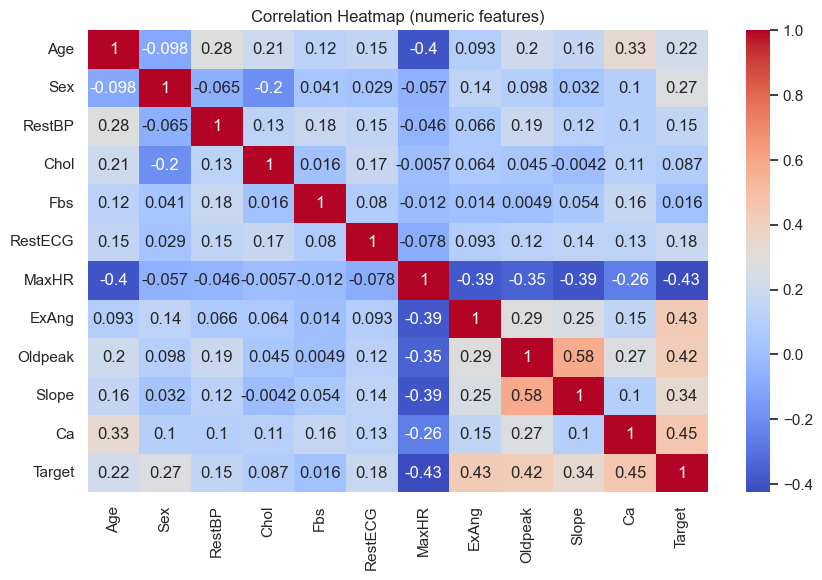

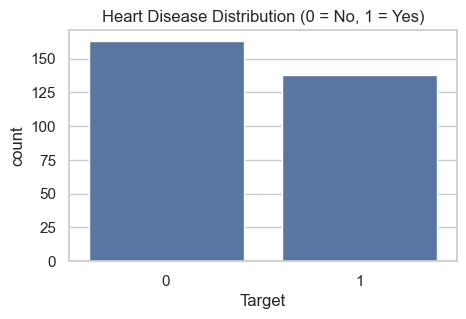

In [4]:

# Correlation heatmap (numeric only)
plt.figure(figsize=(10,6))
numeric_df = df_raw.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (numeric features)")
plt.show()

# Target distribution
plt.figure(figsize=(5,3))
sns.countplot(x="Target", data=df_raw)
plt.title("Heart Disease Distribution (0 = No, 1 = Yes)")
plt.show()


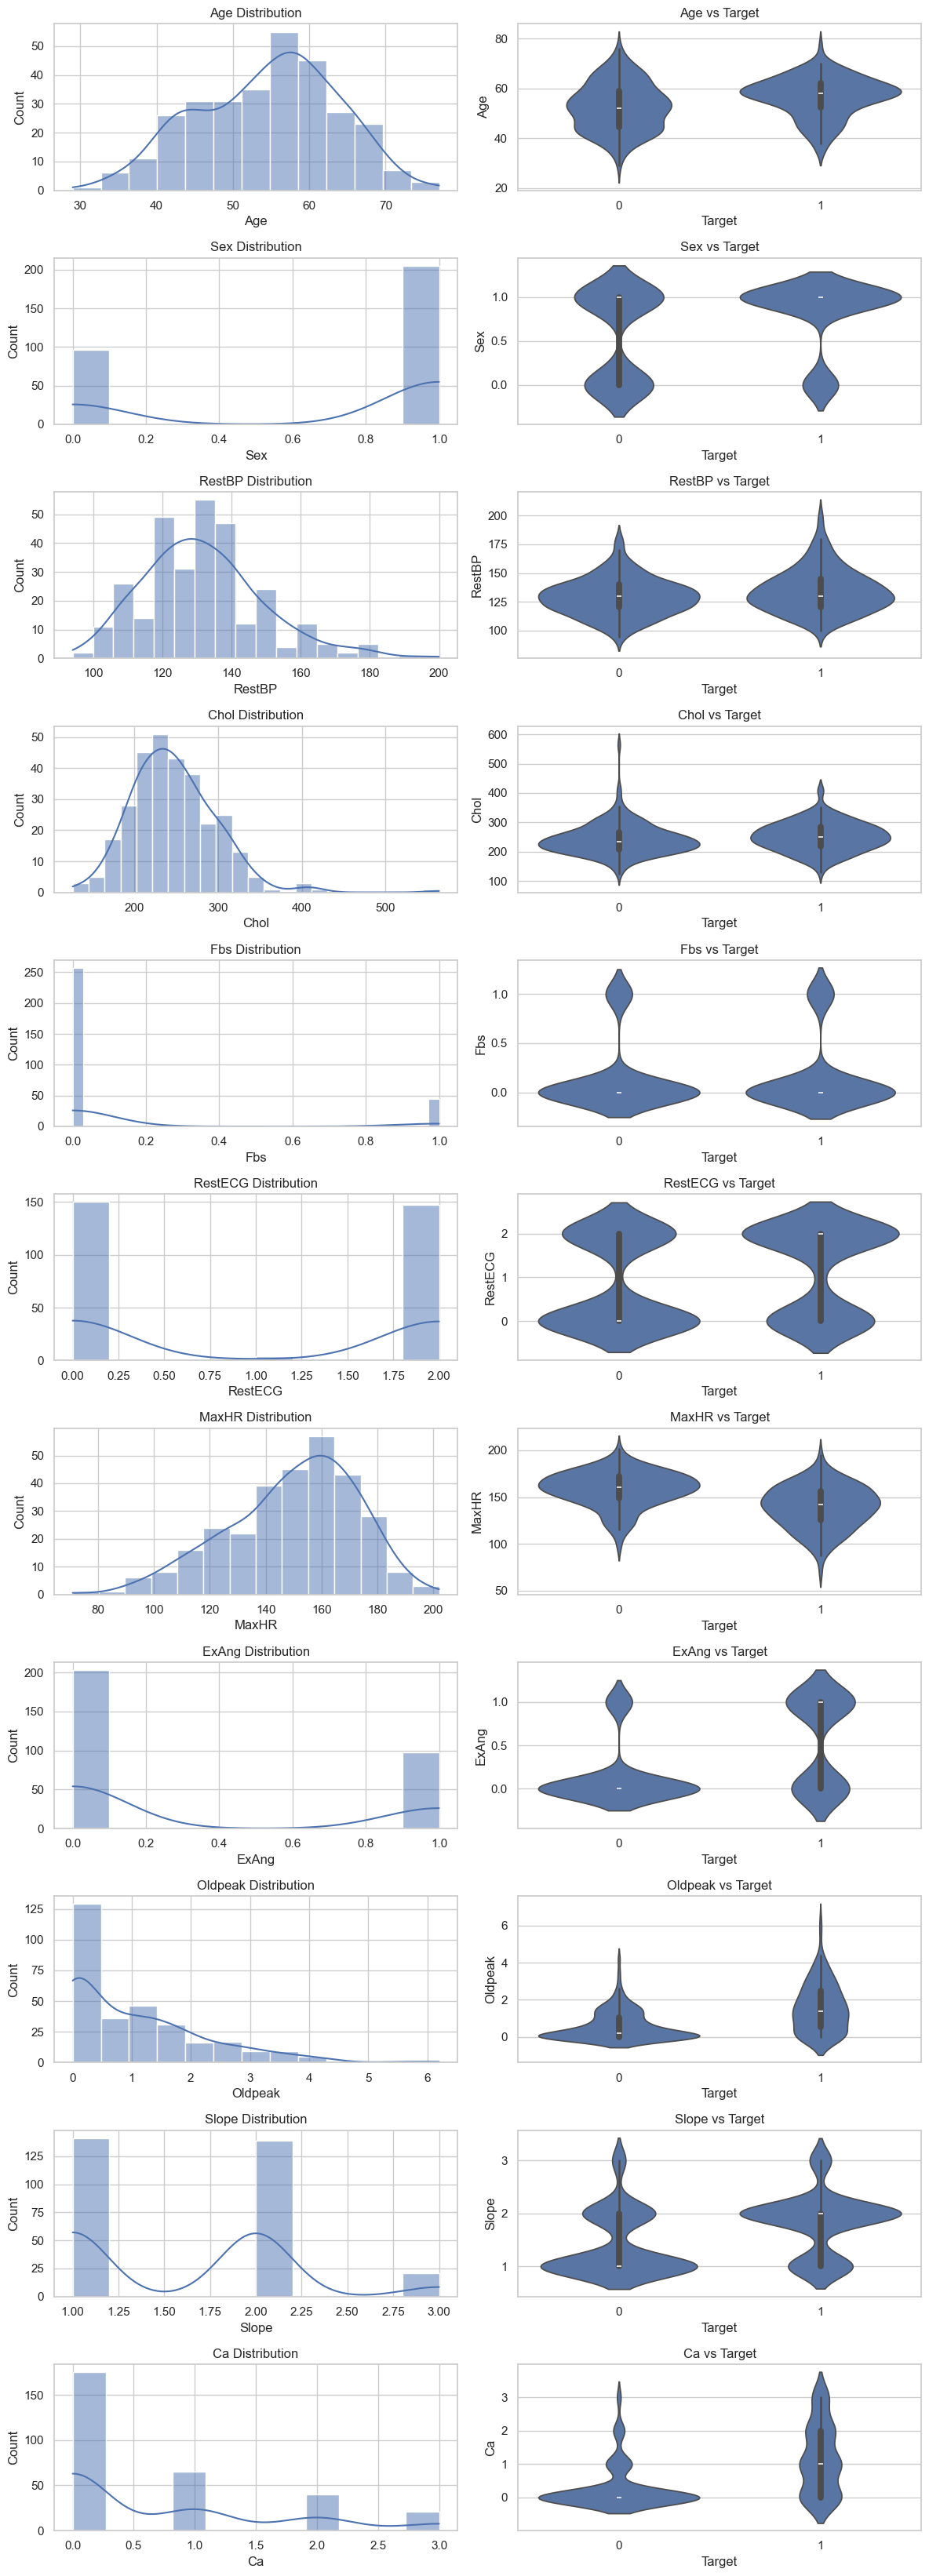

In [5]:

# Continuous feature distributions by Target
cont_cols = [c for c in df_raw.select_dtypes(include=[np.number]).columns if c != "Target"]

fig, axes = plt.subplots(nrows=len(cont_cols), ncols=2, figsize=(12, 3*len(cont_cols)))
axes = np.atleast_2d(axes)

for i, col in enumerate(cont_cols):
    sns.histplot(df_raw, x=col, kde=True, ax=axes[i][0])
    axes[i][0].set_title(f"{col} Distribution")
    sns.violinplot(x="Target", y=col, data=df_raw, ax=axes[i][1])
    axes[i][1].set_title(f"{col} vs Target")

plt.tight_layout()
plt.show()


In [6]:

# Encode categorical features for ML
df = df_raw.copy()
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
df = pd.get_dummies(df, columns=obj_cols, drop_first=True)

print("Encoded shape:", df.shape)
df.head()


Encoded shape: (301, 17)


,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Target,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable
0,63,1,145,233,1,2,150,0,2.3,3,0,0,False,False,True,False,False
1,67,1,160,286,0,2,108,1,1.5,2,3,1,False,False,False,True,False
2,67,1,120,229,0,2,129,1,2.6,2,2,1,False,False,False,False,True
3,37,1,130,250,0,0,187,0,3.5,3,0,0,True,False,False,True,False
4,41,0,130,204,0,2,172,0,1.4,1,0,0,False,True,False,True,False


In [7]:

X = df.drop(columns=["Target"])
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((225, 16), (76, 16))

In [8]:

pipe_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42))
])

pipe_svm = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", SVC(kernel="rbf", probability=True, random_state=42))
])

rf = RandomForestClassifier(n_estimators=300, random_state=42)
dt = DecisionTreeClassifier(random_state=42)

models = {
    "LogisticRegression": pipe_lr,
    "SVM (RBF)": pipe_svm,
    "RandomForest": rf,
    "DecisionTree": dt
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
print("Cross-validation results:\n")
for name, mdl in models.items():
    acc = cross_val_score(mdl, X, y, cv=cv, scoring="accuracy")
    auc = cross_val_score(mdl, X, y, cv=cv, scoring="roc_auc")
    results[name] = {"ACC": acc.mean(), "AUC": auc.mean()}
    print(f"{name:17s} ACC: {acc.mean():.3f} ± {acc.std():.3f}   AUC: {auc.mean():.3f} ± {auc.std():.3f}")


Cross-validation results:

LogisticRegression ACC: 0.840 ± 0.048   AUC: 0.901 ± 0.041
SVM (RBF)         ACC: 0.834 ± 0.037   AUC: 0.907 ± 0.038
RandomForest      ACC: 0.800 ± 0.052   AUC: 0.900 ± 0.021
DecisionTree      ACC: 0.734 ± 0.038   AUC: 0.732 ± 0.037


In [9]:

# Train and evaluate on hold-out test set
best_models = {}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    print(f"\n{name} (Test Set):")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    best_models[name] = mdl



LogisticRegression (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.90      0.80      0.85        35

    accuracy                           0.87        76
   macro avg       0.87      0.86      0.87        76
weighted avg       0.87      0.87      0.87        76

Confusion Matrix:
 [[38  3]
 [ 7 28]]

SVM (RBF) (Test Set):
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        41
           1       0.93      0.80      0.86        35

    accuracy                           0.88        76
   macro avg       0.89      0.88      0.88        76
weighted avg       0.89      0.88      0.88        76

Confusion Matrix:
 [[39  2]
 [ 7 28]]

RandomForest (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        41
           1       0.85      0.80      0.82        35

    accuracy             

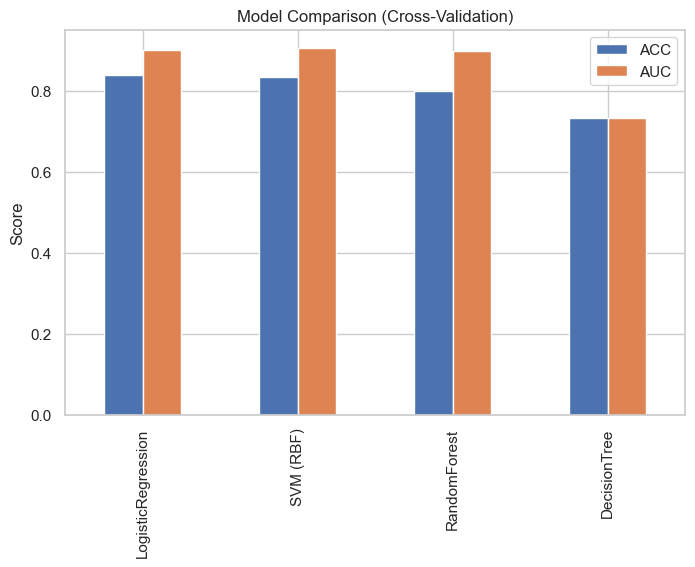

,ACC,AUC
LogisticRegression,0.840328,0.901059
SVM (RBF),0.833716,0.906687
RandomForest,0.800492,0.900043
DecisionTree,0.734044,0.732481


In [10]:

# Compare model accuracy visually
res_df = pd.DataFrame(results).T
res_df.plot(kind="bar", figsize=(8,5))
plt.title("Model Comparison (Cross-Validation)")
plt.ylabel("Score")
plt.show()

res_df


In [11]:
# 🔮 Demo: Predict on a new patient

# Let's take one patient from the test set
example = X_test.iloc[[0]]   # pick first row from test data
print("Patient data (features):\n")
display(example)

# Predict using the best model (Random Forest in this case)
model = best_models["RandomForest"]
prediction = model.predict(example)[0]

print("\n✅ Prediction Result:")
if prediction == 1:
    print("⚠️ The model predicts: Heart Disease (at risk)")
else:
    print("💚 The model predicts: No Heart Disease (healthy)")


Patient data (features):



,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable
279,47,1,130,253,0,0,179,0,0.0,1,0,True,False,False,True,False



✅ Prediction Result:
💚 The model predicts: No Heart Disease (healthy)


In [12]:
# 🧑‍⚕️ Interactive Patient Prediction (Patient-Friendly)

def interactive_prediction():
    print("🫀 Heart Health Prediction - Please enter your details\n")
    
    # Basic info
    age = int(input("Enter your Age (in years): "))
    sex = int(input("Enter Sex (1 = Male, 0 = Female): "))
    rest_bp = int(input("Enter Resting Blood Pressure: "))
    
    # Cholesterol input (adds 'don't know' path + patient-facing summary)
    know_chol = input("Do you know your Serum Cholesterol value? (yes/no): ").strip().lower()
    chol_note = None  # for display
    if know_chol in ["yes", "y"]:
        chol = int(input("Enter Serum Cholesterol (mg/dl): "))
        chol_summary = f"Cholesterol (exact): {chol} mg/dL"
    else:
        print("\n⚠️ You don’t know your cholesterol value. Let’s estimate it from a few lifestyle questions.\n")
        diet = input("Do you often eat fried/processed food? (rarely/sometimes/often): ").strip().lower()
        exercise = input("How many days/week do you exercise? (5+/2-4/0-1): ").strip().lower()
        weight = input("Your weight status? (lean/over): ").strip().lower()
        fam = input("Family history of cholesterol/heart disease? (yes/no): ").strip().lower() in ["yes","y"]
        smoke = input("Do you smoke? (yes/no): ").strip().lower() in ["yes","y"]
        bp_high = input("Do you have high BP? (yes/no): ").strip().lower() in ["yes","y"]

        # Score lifestyle risks
        score = 0
        score += 2 if diet == "often" else (1 if diet == "sometimes" else 0)
        score += 2 if exercise == "0-1" else (1 if exercise == "2-4" else 0)
        score += 2 if weight == "over" else 0
        score += 2 if fam else 0
        score += 1 if smoke else 0
        score += 1 if bp_high else 0

        # Map score → rough cholesterol range (use midpoint for model)
        if score <= 1:
            rng = (150, 175); chol = 162; label = "Desirable / Near desirable"
        elif score <= 3:
            rng = (170, 199); chol = 185; label = "Near desirable / Borderline"
        elif score <= 6:
            rng = (200, 239); chol = 220; label = "Borderline high"
        else:
            rng = (240, 270); chol = 255; label = "High"

        chol_note = f"Estimated range: {rng[0]}–{rng[1]} mg/dL · Category: {label}"
        chol_summary = f"Cholesterol (estimated): ~{chol} mg/dL ({chol_note})"
        print(f"\n👉 Using ~{chol} mg/dL for prediction ({chol_note})\n")

    max_hr = int(input("Enter Maximum Heart Rate achieved: "))
    
    # Simplify ExAng (Exercise Induced Angina)
    ex_ang_input = input("Do you feel chest pain during exercise? (yes/no): ").strip().lower()
    ex_ang = 1 if ex_ang_input in ["yes", "y"] else 0
    
    # Simplify Oldpeak (ST Depression)
    oldpeak_input = input("Do you feel shortness of breath or discomfort during exercise? (yes/no): ").strip().lower()
    oldpeak = 2.0 if oldpeak_input in ["yes", "y"] else 0.0
    
    # Chest pain type (with explanations)
    print("\n👉 Chest Pain Type Options:")
    print(" - typical       : Usual chest pain during exertion")
    print(" - nontypical    : Unusual chest pain, not always linked to exertion")
    print(" - nonanginal    : Chest discomfort not related to the heart")
    print(" - asymptomatic  : No chest pain at all (patient feels fine, but disease may still exist silently)")
    chest_pain = input("Enter Chest Pain Type: ").strip().lower()
    
    # Thalassemia (Thal) options (with explanations)
    print("\n👉 Thalassemia (Thal) Options:")
    print(" - normal      : Normal blood flow to the heart")
    print(" - fixed       : Blood flow problem that is always present (permanent damage)")
    print(" - reversable  : Blood flow problem only during exercise, improves at rest")
    print("\nℹ️ Note: Blood flow type is usually known after a medical test (Thallium Stress Test).")
    thal = input("Enter Thal value: ").strip().lower()
    
    # Build dictionary
    patient_dict = {
        'Age': age,
        'Sex': sex,
        'RestBP': rest_bp,
        'Chol': chol,
        'MaxHR': max_hr,
        'ExAng': ex_ang,
        'Oldpeak': oldpeak,
        'Target': 0  # placeholder
    }
    
    # Convert to DataFrame
    patient_df = pd.DataFrame([patient_dict])
    patient_df['ChestPain'] = chest_pain
    patient_df['Thal'] = thal
    
    # Encode to match training data
    patient_encoded = pd.get_dummies(patient_df, columns=['ChestPain','Thal'], drop_first=True)
    patient_encoded = patient_encoded.reindex(columns=X_train.columns, fill_value=0)
    
    # Predict with Random Forest
    model = best_models["RandomForest"]
    prediction = model.predict(patient_encoded)[0]
    
    # ----- Patient-facing output -----
    print("\n================= RESULT =================")
    print(chol_summary)  # shows exact OR estimated range/category
    if prediction == 1:
        print("⚠️ The model predicts: Heart Disease (at risk)")
    else:
        print("💚 The model predicts: No Heart Disease (healthy)")
    print("==========================================")



# 🔮 Run this to test interactively
interactive_prediction()


🫀 Heart Health Prediction - Please enter your details


⚠️ You don’t know your cholesterol value. Let’s estimate it from a few lifestyle questions.


👉 Using ~185 mg/dL for prediction (Estimated range: 170–199 mg/dL · Category: Near desirable / Borderline)


👉 Chest Pain Type Options:
 - typical       : Usual chest pain during exertion
 - nontypical    : Unusual chest pain, not always linked to exertion
 - nonanginal    : Chest discomfort not related to the heart
 - asymptomatic  : No chest pain at all (patient feels fine, but disease may still exist silently)

👉 Thalassemia (Thal) Options:
 - normal      : Normal blood flow to the heart
 - fixed       : Blood flow problem that is always present (permanent damage)
 - reversable  : Blood flow problem only during exercise, improves at rest

ℹ️ Note: Blood flow type is usually known after a medical test (Thallium Stress Test).

================= RESULT =================
Cholesterol (estimated): ~185 mg/dL (Estimated range: 170–199 mg/dL ·